<h1>Dota 2 total kills analysis

<i>In this notebook I explore the idea of betting on the total score of a given dota2 game. I at first just consider the global average total scores of proffesional dota2 games which seems very promising at first but falls short in an actual trial. This suggests that we must consider each team uniquely as do bet365 with their odds. With this in mind I then predict the games using each teams average kills and deaths for the season. With this method there is no way to trial on past games and so live games must be used. I scraped games for 2 weeks from bet365 which only totalled around 60 series with 2 or 3 games a series. I finish by trialling betting according to this method with what seems to be great success.

Bet365 gives 5/6 odds for the total kills of any given game to be above or below 52.5. Let's have a look at recent pro games to see whether this is an accurate splitting point.

Load in the matches from a csv file from datdota.com

In [1]:
import pandas as pd
import re
import scipy.stats
import math
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
#Load the file
df = pd.read_csv('Matches.csv')
df = df.iloc[0:100, :]

#Load the teams file
df_teams = pd.read_csv('Teams.csv')

#Consider just top10 teams
#df_teams = df_teams.iloc[:10,:]

#make a list of the top 50 teams
team_list = []

for team in df_teams['Unnamed: 0']:
    team_list.append(team)
        
df_teams.head()

#only consider the games from teams in the top 20
def top20(team):
    if team in team_list:
        return True
    else:
        return False

#df['top20'] = df['Radiant Team'].apply(top20)
#df= df[df['top20']]
df.shape[0]

#We are just interested in the games IDs and the kill scores
df = df[['Match ID', 'Kills Score']]

df_teams

,Unnamed: 0,Unnamed: 1,Total Count,Wins,Losses,Winrate,As Radiant,As Dire,Kills,Deaths,Assists,GPM,XPM,Last Hits,Denies,Overall,In Wins,In Losses,Shift
0,Thunder Predator,Thunder Predator,135,76,59,56.30%,87,48,26.70,25.41,60.81,2103,2537,798,38,34:41,32:29,37:32,-05:02
1,Quincy Crew,Quincy Crew,130,103,27,79.23%,76,54,32.68,20.42,75.84,2260,2774,870,42,35:15,34:18,38:54,-04:36
2,Infamous Gaming,Infamous Gaming,128,65,63,50.78%,35,93,28.77,29.34,63.52,2147,2650,841,43,34:55,34:08,35:45,-01:37
3,4 Zoomers,4 Zoomers,120,67,53,55.83%,61,59,26.72,25.56,62.16,2131,2586,812,41,34:31,32:51,36:38,-03:47
4,EHOME,EHOME,108,60,48,55.56%,51,57,24.74,21.83,58.74,2206,2680,892,41,34:27,34:01,35:01,-01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,SHUCKLE,SHUCKLE,1,0,1,0.00%,1,0,6.00,19.00,9.00,1466,1543,235,15,12:49,-,12:49,-
154,Ancient Killers,Ancient Killers,1,0,1,0.00%,0,1,20.00,40.00,48.00,1788,2140,920,48,47:41,-,47:41,-
155,Team Solid,Team Solid,1,0,1,0.00%,0,1,7.00,30.00,19.00,1606,1815,533,42,25:23,-,25:23,-
156,Level Up,Level Up,1,0,1,0.00%,0,1,14.00,41.00,43.00,1375,1716,385,37,26:41,-,26:41,-


We need total score rather than each teams score and so will add them together.

In [3]:
i=0
for score in df['Kills Score']:
    score_list = score.split('-')
    df.iloc[i,1] = int(score_list[0]) + int(score_list[1])
    i+=1
    
df.head(20)

,Match ID,Kills Score
0,5718100700,72
1,5718045399,31
2,5717987182,26
3,5717905633,34
4,5717842177,28
5,5717752241,37
6,5717651850,47
7,5717512265,75
8,5717471671,66
9,5717412180,26


Let's group the scores together into easily viewable categories and take a look at what we have.

<AxesSubplot:>

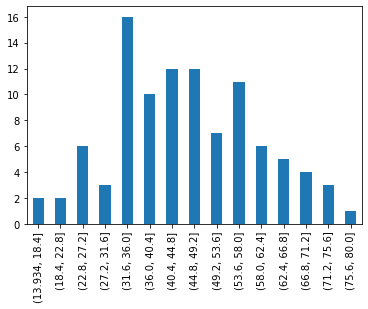

In [4]:
categories = pd.cut(df['Kills Score'], 15)

categories.value_counts(sort=False).plot.bar()

52.5 does seem to be near the average but let's delve a litle deeper.

In [5]:
low_scores_proportion = df[df['Kills Score'] < 52.5].shape[0]/df.shape[0]
print('The mean value is ' + str(df['Kills Score'].mean()) + '.')
print('The standard deviation is ' + str(df['Kills Score'].std()) + '.')
print(str(low_scores_proportion*100) + '% of the scores are below 52.5.')
expected_return = (low_scores_proportion*(5/6)) - (1 - low_scores_proportion)
print('Betting on the lower total score will give an expected return of £' + str(expected_return) + ' per £1 bet.')

The mean value is 45.46.
The standard deviation is 13.97285969588216.
69.0% of the scores are below 52.5.
Betting on the lower total score will give an expected return of £0.2649999999999999 per £1 bet.


To have a positive expected return we require the low scoring games to make up over 6/11s of the games. Let's test the hypothesis that the proportion is more than this. So we assume that that in reality 6/11 games will have total scores higher than 52.5 and find the chances that our observed proportion is what we'll get.

In [6]:
#Set the variables of our binomial distribution based on this hypothesis X~B(6/11, n)
p = 6/11
q = 1 - p
n = df.shape[0]

#Approximate this as a normal distribution X~N(pn, pqn)
mean = p*n
var = p*q*n

#P(X > low_scores_proportion*n) = P(Z > (low_scores*n - mean)/std)
result = scipy.stats.norm(0, 1).cdf(((low_scores_proportion*n)-mean)/math.sqrt(var))
print('The chance that our observed number of low scoring games is more than the needed proportion is ' + str(result*100) + '%.')

The chance that our observed number of low scoring games is more than the needed proportion is 99.81515510787165%.


We get such a high confidence since n is so massive.

Having figuratively bet according to these findings over a week or so, the results were unsuccesful. What we fail to take into account is the individual playstyle and skill of each team. The games that are available to bet on are not well represented in this data set and so it's appropriate to consider each team individually. This can be done easily with the poisson distribution. We consider the teams average kills and deaths. When two teams play each other we take averages of a teams kills with the opposing teams deaths to give a a mean for a poisson distribution ov kills over the length of a game. This will become very clear once we get into it.

We will be using the kills and deaths averages from each team from the 'Teams' csv file which was downloaded approximately 1 week ago (27/11/20). We will keep these numbers as a static estimate of the teams distributions (rather than update for every game that is played).

In [7]:
#Add in the new matches csv file
df_new = pd.read_csv('Matches2.csv')

#Change the date time column to date/time format
df_new['Start Date/Time'] = df_new['Start Date/Time'].apply(lambda x: datetime.strptime(x, '%d %b %Y %H:%M'))

#Only consider the games ince 27/11/20
df_new = df_new[df_new['Start Date/Time'] > datetime.strptime('27/11/20', '%d/%m/%y')]

df_new.head()

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Kills Score,Unnamed: 7,Winner,Radiant Team,Radiant Players,Dire Team,Dire Players
0,5727137234,507138.0,12620,2020-12-03 01:23:00,25:43,1543,10-19,"10,19",Dire,Team Aster,"old LaNm, Xxs, Monet, phoenix, BoBoKa",PSG.LGD,"y`Maxine, Faith_bian, XinQ, NothingToSay, 长亭外 ..."
1,5727054459,507138.0,12620,2020-12-03 12:15:00,44:06,2646,28-35,"28,35",Dire,Team Aster,"old LaNm, Xxs, Monet, phoenix, BoBoKa",PSG.LGD,"y`Maxine, Faith_bian, XinQ, NothingToSay, 长亭外 ..."
2,5727000888,507125.0,12620,2020-12-03 11:17:00,25:26,1526,3-23,"3,23",Dire,Team Magma,"Tyz, KAZZ, mianmiam, 无双斗魂, ZC",Royal Never Give Up,"Super, Felixciaoba, Setsu, Srf, Another"
3,5726949567,507125.0,12620,2020-12-03 10:23:00,31:38,1898,6-28,"6,28",Dire,Team Magma,"Tyz, KAZZ, mianmiam, 无双斗魂, ZC",Royal Never Give Up,"Super, Felixciaoba, Setsu, Srf, Another"
4,5726894198,507104.0,12620,2020-12-03 09:12:00,36:28,2188,35-21,"35,21",Radiant,Elephant,"fy, Somnus, 骑牛的, Eurus, Yang",INVICTUS GAMING,"Oli, JT-, kaka, flyfly, Emo"


There were 3 major tournaments that were taking bets on bet365 this week, Realms collide, Epic league and Dota pit China. These each have unique league codes 12531, 12548 and 12620 respectively.

In [8]:
#Looking at only these tournaments
List = [12531,12548,12620]
df_new = df_new[df_new['League'].isin(List)]

#Add a column for the expected number of kills in each game by just taking the average of the kills and deaths of both teams
def expected_kills(row):
    team1_kill = df_teams[df_teams['Unnamed: 0'] == row[9]]['Kills'].iloc[0]
    team2_kill = df_teams[df_teams['Unnamed: 0'] == row[11]]['Kills'].iloc[0]
    team1_death = df_teams[df_teams['Unnamed: 0'] == row[9]]['Deaths'].iloc[0]
    team2_death = df_teams[df_teams['Unnamed: 0'] == row[11]]['Deaths'].iloc[0]
    return ((team1_kill + team2_death)/2) + ((team2_kill + team1_death)/2)

df_new['Expected kills'] = df_new.apply(expected_kills, axis=1)

#Concentrate on the few needed columns
df_new = df_new[['Match ID', 'Kills Score', 'Expected kills']]

#Find the total score as before
i=0
for score in df_new['Kills Score']:
    score_list = score.split('-')
    df_new.iloc[i,1] = int(score_list[0]) + int(score_list[1])
    i+=1
    
#Add in the mean from the old matches data set for comparison
df_new['Old mean'] = df['Kills Score'].mean()
df_new

,Match ID,Kills Score,Expected kills,Old mean
0,5727137234,29,47.100,45.46
1,5727054459,63,47.100,45.46
2,5727000888,26,43.965,45.46
3,5726949567,34,43.965,45.46
4,5726894198,56,47.680,45.46
...,...,...,...,...
140,5718362753,50,53.630,45.46
141,5718328390,47,53.630,45.46
142,5718282018,55,51.360,45.46
143,5718248057,47,51.360,45.46


Now we can compare the difference of the total scores and the expected scores using the new method and from the mean that we found earlier. For this we will use mean absolute error (MAE).

In [9]:
Mean_difference1 = []
Mean_difference2 = []
mean = df['Kills Score'].mean()
for score, ex1 in zip(df_new['Kills Score'], df_new['Expected kills']):
    Mean_difference1.append(abs(score-ex1))
    Mean_difference2.append(abs(score-mean))
    
error1 = sum(Mean_difference1)/len(Mean_difference1)
error2 = sum(Mean_difference2)/len(Mean_difference2)

print('The mean absolute error with the new method is ' + str(error1) + '.')
print('The mean absolute error with the old method is ' + str(error2) + '.')

The mean absolute error with the new method is 11.712107843137256.
The mean absolute error with the old method is 12.441568627450973.


To see whether this slight improvement can be implemented, we need to compare our estimations with actual betting odds and results. This will need to be done in real time since there is no past odds database for total kills.

In [10]:
#Import excel sheet of bets
bets_df = pd.read_csv('Total_Kills.csv')
bets_df.head()

#Import latest matches

,Date,Team1,Team2,Amount
0,03/12/2020,Team Secret,Virtus.pro,45.5
1,03/12/2020,Nigma,ViKin.gg,54.5
2,04/12/2020,Team Liquid,mudgolems,50.5
3,04/12/2020,Natus Vincere,ViKin.gg,47.5
4,04/12/2020,Virtus.pro,Alliance,49.5


In [11]:
#Find expected total kills from the teams df as done above
def expected_kills2(row):
    team1_kill = df_teams[df_teams['Unnamed: 0'] == row[1]]['Kills'].iloc[0]
    team2_kill = df_teams[df_teams['Unnamed: 0'] == row[2]]['Kills'].iloc[0]
    team1_death = df_teams[df_teams['Unnamed: 0'] == row[1]]['Deaths'].iloc[0]
    team2_death = df_teams[df_teams['Unnamed: 0'] == row[2]]['Deaths'].iloc[0]
    return ((team1_kill + team2_death)/2) + ((team2_kill + team1_death)/2)

bets_df['Expected kills'] = bets_df.apply(expected_kills2, axis=1)

bets_df.head()

,Date,Team1,Team2,Amount,Expected kills
0,03/12/2020,Team Secret,Virtus.pro,45.5,45.930
1,03/12/2020,Nigma,ViKin.gg,54.5,52.785
2,04/12/2020,Team Liquid,mudgolems,50.5,47.715
3,04/12/2020,Natus Vincere,ViKin.gg,47.5,46.525
4,04/12/2020,Virtus.pro,Alliance,49.5,49.415


The similarity in the predicted total kills and the betting websites predictions are remarkably similar. Which means the method here is a good one but also might indicate that the betting websites are doing the same method.

Text(0, 0.5, 'Total kills prediciton')

<Figure size 432x288 with 0 Axes>

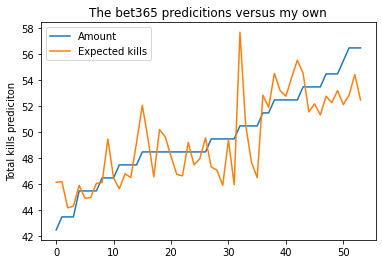

In [12]:
plt.figure()
bets_sorted = bets_df.sort_values('Amount')
bets_sorted = bets_sorted.reset_index()
bets_sorted[['Amount', 'Expected kills']].plot()
plt.title('The bet365 predicitions versus my own')
plt.ylabel('Total kills prediciton')

A new up to date matches dataframe is added to check the accuracy of each prediction.

In [13]:
#grab the matches
check_df = pd.read_csv('Matches3.csv')

#Change the dates to match the bets dataframe
check_df['Start Date/Time'] = check_df['Start Date/Time'].apply(lambda x: datetime.strptime(x, '%d %b %Y %H:%M').strftime('%d/%m/%Y'))

check_df.tail()

,Match ID,Series,League,Start Date/Time,Match Length,Duration (secs),Kills Score,Unnamed: 7,Winner,Radiant Team,Radiant Players,Dire Team,Dire Players
4995,5320868488,421801.0,11370,29/03/2020,53:11,3191,39-35,"39,35",Radiant,Vici Gaming,"Ori, Eurus, Pyw, Yang, Dy",PSG.LGD,"xNova, Chalice, fy, Somnus, old eLeVeN"
4996,5320797456,421797.0,11806,29/03/2020,23:36,1416,16-9,"16,9",Radiant,Sparking Arrow Gaming,"骑牛的, Felixciaoba, 圣子华炼, Op, Angel",EHOME,"Sylar, y`Maxine, Faith_bian, XinQ, NothingToSay"
4997,5320740298,421760.0,11370,29/03/2020,23:24,1404,30-11,"30,11",Radiant,Vici Gaming,"Ori, Eurus, Pyw, Yang, Dy",INVICTUS GAMING,"Oli, JT-, kaka, flyfly, Emo"
4998,5320633500,421760.0,11370,29/03/2020,35:53,2153,29-19,"29,19",Radiant,Vici Gaming,"Ori, Eurus, Pyw, Yang, Dy",INVICTUS GAMING,"Oli, JT-, kaka, flyfly, Emo"
4999,5320544843,421760.0,11370,29/03/2020,40:46,2446,19-28,"19,28",Dire,Vici Gaming,"Ori, Eurus, Pyw, Yang, Dy",INVICTUS GAMING,"Oli, JT-, kaka, flyfly, Emo"


Here we add the actual results to the bets dataframe.

In [16]:
def find_add_results(row):
    result = ''
    for date, team1, team2, score in zip(check_df['Start Date/Time'], check_df['Radiant Team'], check_df['Dire Team'], check_df['Kills Score']):
        if date == row[0]:
            if team1 == row[1] or team2 == row[1]:
                if team1 == row[2] or team2 == row[2]:
                    result = result + ',' + score
    return result

bets_df['Results'] = bets_df.apply(find_add_results, axis=1)

bets_df.head()

,Date,Team1,Team2,Amount,Expected kills,Results
0,03/12/2020,Team Secret,Virtus.pro,45.5,45.930,",9-18,12-30"
1,03/12/2020,Nigma,ViKin.gg,54.5,52.785,",33-16,25-34,23-28"
2,04/12/2020,Team Liquid,mudgolems,50.5,47.715,",4-23,3-25"
3,04/12/2020,Natus Vincere,ViKin.gg,47.5,46.525,",17-3,46-29,33-13"
4,04/12/2020,Virtus.pro,Alliance,49.5,49.415,",34-12,34-11,29-6"


Now to check whether betting would have made any money, we will assume 5/6 odds with £1 bets on each game and assume we bet on above or below the given total score depending on our predictions.

In [23]:
def calculate_gains(row):
    gains = 0
    over_under_boolean = 1
    if float(row[4]) < float(row[3]):
        over_under_boolean = -1
    results = row[5].split(',')
    results.remove('')
    for result in results:
        final_split = result.split('-')
        total_score = 0
        for score in final_split:
            total_score += int(score)
        if total_score*(over_under_boolean) > float(row[3])*(over_under_boolean):
            gains += 5/6
        else:
            gains -= 1
    return gains
    
bets_df['Gains'] = bets_df.apply(calculate_gains, axis=1)

bets_df.head()

,Date,Team1,Team2,Amount,Expected kills,Results,Gains
0,03/12/2020,Team Secret,Virtus.pro,45.5,45.930,",9-18,12-30",-2.000000
1,03/12/2020,Nigma,ViKin.gg,54.5,52.785,",33-16,25-34,23-28",0.666667
2,04/12/2020,Team Liquid,mudgolems,50.5,47.715,",4-23,3-25",1.666667
3,04/12/2020,Natus Vincere,ViKin.gg,47.5,46.525,",17-3,46-29,33-13",0.666667
4,04/12/2020,Virtus.pro,Alliance,49.5,49.415,",34-12,34-11,29-6",2.500000


Finally tallying up all gains to get a result.

In [25]:
print(bets_df['Gains'].sum(axis=0))

21.333333333333332


Which gives an average gain per bet of:

In [ ]:
print(bets_df['Gains'].sum(axis=0)/bets_df.shape[0])

This is a huge gain per bet. Having first failed (spectacularly), this is a great result. There are two major problems that I now face. Firstly this is a very small sample size and I have learned the hard way not to be very trustful of such results. Secondly, dota is going to undergo a new patch today which will totally change the way tat proffesional teams play making all previous data obselete. Either way, I had a lot of fun exploring this interesting avenue and have learned something that may be used in the future.